# Cloud locking vs. cloud and water vapor locking

This script generates figure S1: total response and cloud impact from ICON simulations with locked clouds and interactive water vapor and from ICON simulations with locked clouds and locked water vapor.

### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import helper_functions as fct

### Load own colorbar

In [2]:
mymap, mymap2 = fct.generate_mymap()

### Specify months and seasons of the year

In [3]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

### Specify simulations that are analyzed and impacts that are calculated 

* xx_cld: locked clouds, interactive water vapor
* xx_cldvap: locked clouds, locked water vapor

In [4]:
runs_cld = ['T1C1', 'T2C2', 'T2C1', 'T1C2']
runs_cldvap = ['T1C1W1', 'T2C2W2', 'T1C2W1', 'T1C1W2',
               'T1C2W2', 'T2C1W1', 'T2C2W1', 'T2C1W2']

response_cld = ['total', 'SST', 'cloud']
response_cldvap = ['total', 'SST', 'cloud', 'water vapor']

### Read ICON data with locked clouds and interactive water vapor

In [5]:
ipath = '../../ICON-NWP_lockedclouds/'
u850_icon_cld = {}
for run in runs_cld:
    print('reading ' + run)
    ifile = 'ICON-NWP_AMIP_' + run + '_3d_mm.nc'
    ncfile = nc.Dataset(ipath + ifile, 'r')
    lats = np.array(ncfile.variables['lat'][:].data)
    lons = np.array(ncfile.variables['lon'][:].data)
    levs = np.array(ncfile.variables['lev'][:].data)
    uwind = np.array(ncfile.variables['u'][:].data)
    ncfile.close()    
    # get zonal wind at 850 hPa
    levind850 = (np.abs(levs-85000)).argmin() # index of 850 hPa level
    u850_icon_cld[run] = uwind[:, levind850, :, :]
    del levs, uwind, levind850
    del ifile, ncfile
del run, ipath

reading T1C1
reading T2C2
reading T2C1
reading T1C2


### Read ICON data with locked clouds and locked water vapor

In [6]:
ipath = '../../ICON-NWP_lockedcloudsandwatervapor/'
u850_icon = {}
for run in runs_cldvap:
    print('reading ' + run)
    ifile = 'ICON-NWP_AMIP_' + run + '_3d_mm.uwind.nc'
    ncfile = nc.Dataset(ipath + ifile, 'r')
    #lats = np.array(ncfile.variables['lat'][:].data)
    #lons = np.array(ncfile.variables['lon'][:].data)
    levs = np.array(ncfile.variables['lev'][:].data)
    uwind = np.array(ncfile.variables['u'][:].data)
    ncfile.close()    
    # get zonal wind at 850 hPa
    levind850 = (np.abs(levs-85000)).argmin() # index of 850 hPa level
    u850_icon[run] = uwind[:, levind850, :, :]
    del levs, uwind, levind850
    del ifile, ncfile
del run, ipath

reading T1C1W1
reading T2C2W2
reading T1C2W1
reading T1C1W2
reading T1C2W2
reading T2C1W1
reading T2C2W1
reading T2C1W2


### Calculate DJF mean

In [7]:
# locked clouds
u850_icon_cld_djf = {}
for run in runs_cld:
    u850_icon_cld_djf[run] = fct.calcMonthlyandSeasonMean(u850_icon_cld[run],
                                                          months, seasons)[1]['DJF']
del run

# locked clouds and locked water vapor
u850_icon_djf = {}
for run in runs_cldvap:
    u850_icon_djf[run] = fct.calcMonthlyandSeasonMean(u850_icon[run],
                                                      months, seasons)[1]['DJF']
del run

del u850_icon_cld, u850_icon

### Calculate DJF responses and decompose the total response into contributions from changes in SST, clouds and water vapor

In [8]:
# locked clouds
du850_icon_cld = np.full((len(response_cld), len(lats),
                          len(lons)), np.nan, dtype=float)
du850_icon_cld[0, :, :], du850_icon_cld[1, :, :], du850_icon_cld[2, :, :] = \
  fct.calc_impacts_timmean(u850_icon_cld_djf['T1C1'], u850_icon_cld_djf['T2C2'],
                           u850_icon_cld_djf['T1C2'], u850_icon_cld_djf['T2C1'])

# locked clouds and locked water vapor
du850_icon = np.full((len(response_cldvap), len(lats),
                     len(lons)), np.nan, dtype=float)
du850_icon[0, :, :], du850_icon[1, :, :], du850_icon[2, :, :], \
du850_icon[3, :, :] = \
  fct.calc_3impacts_timmean(u850_icon_djf['T1C1W1'], u850_icon_djf['T2C2W2'],
                            u850_icon_djf['T1C2W2'], u850_icon_djf['T2C1W1'],
                            u850_icon_djf['T1C2W1'], u850_icon_djf['T1C1W2'],
                            u850_icon_djf['T2C2W1'], u850_icon_djf['T2C1W2'])

### Plot total response and cloud impact for both simulation setups and add differences between the two setups

Shift the longitudes from 0deg...360deg to -90deg...270deg for visualization reasons

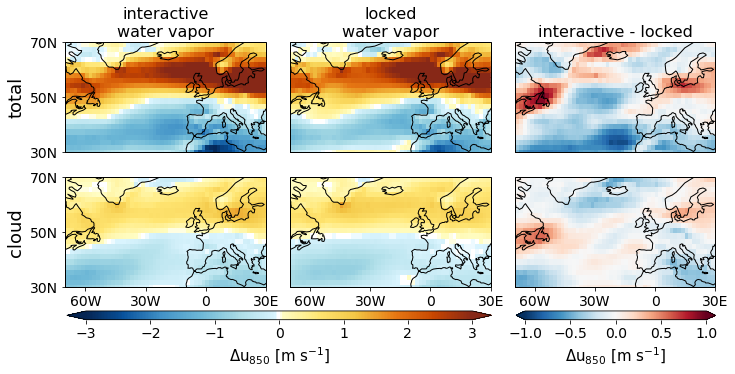

In [9]:
# shift longitudes
du850_icon_cld_shift, lons_shift = fct.shiftgrid_copy(90., du850_icon_cld,
                                                      lons, start=False)
du850_icon_shift, _ = fct.shiftgrid_copy(90., du850_icon, lons, start=False)

vlim = 3
vlim_diff = 1

proj = ccrs.PlateCarree(central_longitude=-90)
fig, ax = plt.subplots(2, 3, figsize=(10, 4.5),
                       subplot_kw=dict(projection=proj))
for i in range(ax.shape[0]):
    for k in range(ax.shape[1]):
        ax[i, k].coastlines(rasterized=True)
        ax[i, k].set_aspect('auto')
        ax[i, k].tick_params(labelsize=14)
        # extended North Atlantic region
        ax[i, k].set_extent([-70, 30, 30, 70], ccrs.PlateCarree())
        # set xticks and yticks for longitudes and latitudes
        # xaxis: longitudes
        ax[1, k].set_xticks([-60, -30, 0, 30], crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(#zero_direction_label=True,
                                            degree_symbol='',
                                            dateline_direction_label=True)
        ax[1, k].xaxis.set_major_formatter(lon_formatter)
        del lon_formatter
    del k
    # yaxis: latitudes
    ax[i, 0].set_yticks([30, 50, 70], crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter(degree_symbol='')
    ax[i, 0].yaxis.set_major_formatter(lat_formatter)
    del lat_formatter
del i
# ICON (locked clouds)
cf = ax[0, 0].pcolormesh(lons_shift, lats,
                         du850_icon_cld_shift[response_cld.index('total'), :, :],
                         vmin=-vlim, vmax=vlim, cmap=mymap2,
                         rasterized=True, transform=ccrs.PlateCarree())
ax[1, 0].pcolormesh(lons_shift, lats,
                    du850_icon_cld_shift[response_cld.index('cloud'), :, :],
                    vmin=-vlim, vmax=vlim, cmap=mymap2,
                    rasterized=True, transform=ccrs.PlateCarree())
# ICON (locked clouds and locked water vapor)
ax[0, 1].pcolormesh(lons_shift, lats,
                    du850_icon_shift[response_cldvap.index('total'), :, :],
                    vmin=-vlim, vmax=vlim, cmap=mymap2,
                    rasterized=True, transform=ccrs.PlateCarree())
ax[1, 1].pcolormesh(lons_shift, lats,
                    du850_icon_shift[response_cldvap.index('cloud'), :, :],
                    vmin=-vlim, vmax=vlim, cmap=mymap2,
                    rasterized=True, transform=ccrs.PlateCarree())
# difference
cf2 = ax[0, 2].pcolormesh(lons_shift, lats,
                          du850_icon_cld_shift[response_cld.index('total'), :, :] - \
                          du850_icon_shift[response_cldvap.index('total'), :, :],
                          vmin=-vlim_diff, vmax=vlim_diff, cmap='RdBu_r',
                          rasterized=True, transform=ccrs.PlateCarree())
ax[1, 2].pcolormesh(lons_shift, lats,
                    du850_icon_cld_shift[response_cld.index('cloud'), :, :] - \
                    du850_icon_shift[response_cldvap.index('cloud'), :, :],
                    vmin=-vlim_diff, vmax=vlim_diff, cmap='RdBu_r',
                    rasterized=True, transform=ccrs.PlateCarree())

ax[0, 0].set_title('a) locked clouds', fontsize=16)
ax[0, 1].set_title('b) locked clouds and\nwater vapor', fontsize=16)
ax[0, 0].set_title('interactive\nwater vapor', fontsize=16)
ax[0, 1].set_title('locked\nwater vapor', fontsize=16)
ax[0, 2].set_title('interactive - locked', fontsize=16)#difference (a - b)', fontsize=16)

fig.canvas.draw()
fig.tight_layout()

# colorbar for response
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.066, 0.0, 0.59, 0.027]) # left,bottom,width,height
cb = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal', extend='both')
cb.set_label('$\Delta$u$_{850}$ [m s$^{-1}$]', fontsize=15, labelpad=5)
cb.ax.tick_params(labelsize=14)
del cbar_ax, cb, cf
cbar_ax = fig.add_axes([0.69, 0.0, 0.277, 0.027]) # left,bottom,width,height
cb = fig.colorbar(cf2, cax=cbar_ax, orientation='horizontal', extend='both')
cb.set_label('$\Delta$u$_{850}$ [m s$^{-1}$]', fontsize=15, labelpad=5)
cb.ax.tick_params(labelsize=14)
del cbar_ax, cb, cf2

for r, res in enumerate(['total', 'cloud']): # response_cldvap):
    ax[r, 0].text(-0.2, 0.5, res, va='bottom', ha='center',
                  rotation='vertical', rotation_mode='anchor',
                  fontsize=18, transform=ax[r, 0].transAxes)
del r, res

fig.savefig('figure_S1.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del fig, ax, proj

del lons_shift, du850_icon_cld_shift, du850_icon_shift, vlim, vlim_diff